In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

!pip install -qU catboost shap optuna
clear_output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import mannwhitneyu, shapiro, chi2_contingency
import statsmodels.stats.power as power
from itertools import combinations

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

import shap
from catboost import Pool, CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier

np.random.seed(123)

In [3]:
train_root = r'/content/drive/My Drive/data/flight/train.csv'
test_root = r'/content/drive/My Drive/data/flight/test.csv'
TARGET_NAME = 'satisfaction'

In [5]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)
train.set_index('id', drop=True, inplace=True)
test.set_index('id', drop=True, inplace=True)
train.duplicated().astype(int).sum(), test.duplicated().astype(int).sum()

(0, 0)

In [6]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
train.info(show_counts=True)
# feature 21 has nans - we will drop these rows (alternative: predict by IterativeImputer)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 70172 to 62567
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1

In [9]:
train.describe()
# possible outliers in two delay columns: as if we don't know how to replace them and dropping leeds to
# less accurate predictions - we won't do anything
# DBSCAN, IQR, IsolationForest, boxplots

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [10]:
train.describe(include=['object'])

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,103904,103904,103904,103904,103904
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,52727,84923,71655,49665,58879


In [11]:
train[TARGET_NAME].value_counts(normalize=True)

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

In [16]:
cat_cols = train.select_dtypes(include=['object', np.int64]).columns.tolist()

In [6]:
# statistic helper functions

def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

def statistic_output(*columns, df=train, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(include=[np.int64, np.int16, np.float32]).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:  # NOTE: for representative sample we can use non-normal data for ttest
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical influence on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        data.reset_index(inplace=True)
        for column in columns:
            print(column)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['id', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='id', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:  
                        print(f'Categories {a} and {b} can be united.')
                    else:
                        continue
                        #print(f'Categories {a} and {b} have different frequencies with target.')
            print('-'*30)

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)

train, test = [reduce_memory(i) for i in [train, test]]

train[TARGET_NAME] = train[TARGET_NAME].map({'neutral or dissatisfied': 0, 'satisfied': 1}).astype(np.int8)
test[TARGET_NAME] = test[TARGET_NAME].map({'neutral or dissatisfied': 0, 'satisfied': 1}).astype(np.int8)

train.set_index('id', drop=True, inplace=True)
test.set_index('id', drop=True, inplace=True)

train.dropna(inplace=True)
test.dropna(inplace=True)

# counts of positive rates, counting may be usefool for tree models
train['Count_rates'] = train.iloc[:, 6:20].gt(3).sum(axis=1)
test['Count_rates'] = test.iloc[:, 6:20].gt(3).sum(axis=1)

# split in train/valid/test
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_test, y_test = test.drop(TARGET_NAME, axis=1), test[TARGET_NAME]

X_train.shape, X_valid.shape, X_test.shape

Memory usage of dataframe is 19.82 MB
Memory usage after optimization is: 3.96 MB
Decreased by 80.0%
Memory usage of dataframe is 4.95 MB
Memory usage after optimization is: 0.99 MB
Decreased by 80.0%


((82875, 23), (20719, 23), (25893, 23))

In [9]:
cat_cols = train.iloc[:2, 6:20].columns.tolist() + train.select_dtypes(include=['category']).columns.tolist()

In [57]:
statistic_output()
# also we won't unite categories, just apply one-hot encoding (alternative - category_encoders in pipeline)

Factor "Flight Distance" has statistical influence on target (var_a: 638332.60, var_b: 1275444.34). 
Factor "Departure Delay in Minutes" has statistical influence on target (var_a: 2082.94, var_b: 1260.21). 
Factor "Arrival Delay in Minutes" has statistical influence on target (var_a: 2144.40, var_b: 1322.95). 
Factor "Count_rates" has statistical influence on target (var_a: 9.13, var_b: 6.21). 


In [40]:
# constant model parameters
params_model = {
    'eval_metric': 'Accuracy',  # F1, LogLoss 
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 4,
    'early_stopping_rounds': 20,
    'grow_policy': 'SymmetricTree',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    'max_ctr_complexity': 6,
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
    }

In [11]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [61]:
base = CatBoostClassifier(verbose=0)
base.fit(train_pool, eval_set=valid_pool)
base_train_pred = base.predict(X_train)
base_test_pred = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
report(y_train, base_train_pred, y_test, base_test_pred, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.969     0.988     0.978     46957
           1      0.984     0.958     0.971     35918

    accuracy                          0.975     82875
   macro avg      0.976     0.973     0.974     82875
weighted avg      0.975     0.975     0.975     82875

Test
               precision    recall  f1-score   support

           0      0.959     0.979     0.969     14528
           1      0.972     0.946     0.959     11365

    accuracy                          0.965     25893
   macro avg      0.966     0.963     0.964     25893
weighted avg      0.965     0.965     0.965     25893

Train ROC_AUC: 0.998, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0             0      1
satisfaction              
0             14221    307
1               610  10755


In [43]:
def objective(trial):
    param_catboost = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    }
    param_catboost.update(params_model)
    opt_model = CatBoostClassifier(**param_catboost)
    opt_model.fit(train_pool, eval_set=valid_pool)
    # tuning to fit final test data
    y_pred = opt_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)  # using simple accuracy_score as class imbalance is not very high
    
    return score  # cross_val_score().mean() # to get best fitted model params

In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123, multivariate=True), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')
# output removed to free notebook space

In [63]:
params_model = {
    'eval_metric': 'Accuracy',  # F1, LogLoss 
    'loss_function': 'Logloss',
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 6,
    'early_stopping_rounds': 10,
    'grow_policy': 'SymmetricTree',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    'max_ctr_complexity': 4,
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
    'depth': 7,  # 6
    'learning_rate': 0.06533785516109684, # 0.09435400366783142,
    'l2_leaf_reg': 3.0784489112315212, # 3.313171447038294,
    'bagging_temperature': 1.3316124135685716, # 1.165556983587386,
    'subsample': 0.6137651173651318, # 0.88,
    'colsample_bylevel': 0.8796579714902142, # 0.61,
    'boosting_type': 'Ordered', # 'Plain'
    'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
    'Counter:CtrBorderCount=30:CtrBorderType=Uniform:Prior=0.5/1']
    }

In [64]:
# take tuned parameters and tune them customly
catboost = CatBoostClassifier(**params_model)
catboost.fit(train_pool, eval_set=valid_pool)

cat_train_pred = catboost.predict(X_train)
cat_test_pred = catboost.predict(X_test)
cat_train_proba = catboost.predict_proba(X_train)[:,1]
cat_test_proba = catboost.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.963     0.975     0.969     46957
           1      0.966     0.951     0.959     35918

    accuracy                          0.964     82875
   macro avg      0.965     0.963     0.964     82875
weighted avg      0.964     0.964     0.964     82875

Test
               precision    recall  f1-score   support

           0      0.961     0.973     0.967     14528
           1      0.965     0.950     0.957     11365

    accuracy                          0.963     25893
   macro avg      0.963     0.961     0.962     25893
weighted avg      0.963     0.963     0.963     25893

Train ROC_AUC: 0.996, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0             0      1
satisfaction              
0             14133    395
1               567  10798


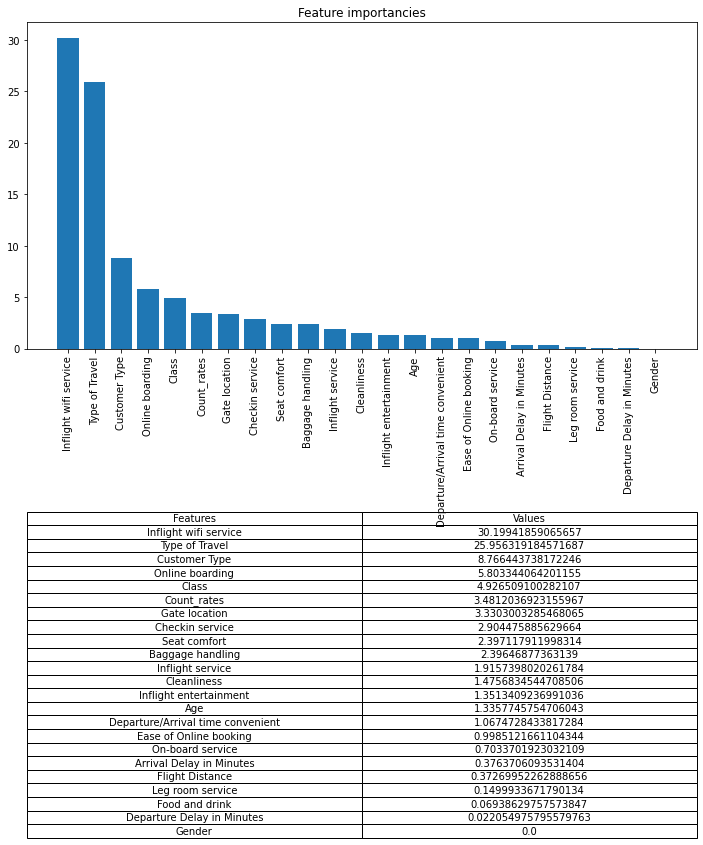

In [65]:
importancies = catboost.feature_importances_
indices = np.argsort(importancies)[::-1]
features = X_train.columns
df = pd.DataFrame(data={'Features': features, 'Values': importancies}).sort_values(by='Values', ascending=False)

plt.figure(figsize=(12,6))
plt.title('Feature importancies')
plt.bar(range(X_train.shape[1]), importancies[indices])
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.table(cellText = df.values,
          colLabels = df.columns, 
          colLoc = 'center', cellLoc = 'center', loc = 'right', bbox = [0, -1.5, 1, 1])
plt.show()

In [66]:
shap.initjs()
shap_values = catboost.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[np.random.randint(len(X_train)),:])

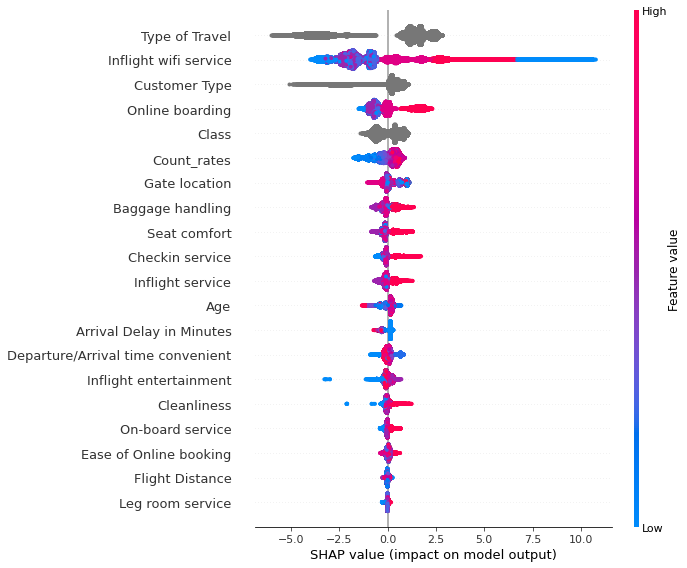

In [67]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

XGBoostClassifier

In [17]:
X_ = pd.get_dummies(X, columns = ["Gender", "Customer Type", "Type of Travel", "Class", 
                                  "Inflight wifi service", "Departure/Arrival time convenient", 
                                  "Ease of Online booking", "Gate location", "Food and drink", 
                                  "Online boarding", "Seat comfort", "Inflight entertainment", 
                                  "On-board service", "Leg room service", "Baggage handling", 
                                  "Checkin service", "Inflight service", "Cleanliness"])

In [18]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

In [19]:
X_test_ = pd.get_dummies(X_test, columns = ["Gender", "Customer Type", "Type of Travel", "Class", 
                                           "Inflight wifi service", "Departure/Arrival time convenient", 
                                           "Ease of Online booking", "Gate location", "Food and drink", 
                                           "Online boarding", "Seat comfort", "Inflight entertainment", 
                                           "On-board service", "Leg room service", "Baggage handling", 
                                           "Checkin service", "Inflight service", "Cleanliness"])

In [20]:
X_train_.columns.difference(X_valid_.columns)

Index([], dtype='object')

In [21]:
X_train_.columns.difference(X_test_.columns)

Index(['Checkin service_0', 'Gate location_0', 'Seat comfort_0'], dtype='object')

In [22]:
# we remove some one-hoted columns from train set as such rates do not appear in test set
X_train_.drop(['Checkin service_0', 'Gate location_0', 'Seat comfort_0'], axis=1, inplace=True)
X_valid_.drop(['Checkin service_0', 'Gate location_0', 'Seat comfort_0'], axis=1, inplace=True)

In [77]:
xgboost_params = {
                  'n_estimators': 300, 
                  'scale_pos_weight': 1.307338938693691,
                  'eval_metric': 'logloss', 
                  'min_child_weight': 1.,
                  'use_label_encoder': False, 
                  'random_state': 42,
}

In [78]:
def xobjective(trial):
    param_xboost = {
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'gamma': trial.suggest_float('gamma', 0., 10.),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.),
                    'tree_method': trial.suggest_categorical('tree_method', ['hist', 'exact']),
                    'max_bin': trial.suggest_int('max_bin', 20, 300),
                    }
    param_xboost.update(xgboost_params)
    opt_model = XGBClassifier(**param_xboost)
    #opt_model.fit(X_train_, y_train_, eval_set=[(X_valid_, y_valid_)], early_stopping_rounds=5, verbose=0)

    score = cross_val_score(opt_model, X=X_train_, y=y_train_, scoring='accuracy', cv=3).mean()
    
    return score

In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123, multivariate=True), direction="maximize")
study.optimize(xobjective, n_trials=100, timeout=600)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')
# output removed to free notebook space

In [80]:
final_xboost_params = {
                      'max_depth': 7,
                      'learning_rate': 0.28164779236170834,
                      'reg_lambda': 2.5558022964925784,
                      'gamma': 9.251324896139861,
                      'subsample': 0.9208349984563582,
                      'colsample_bytree': 0.6786987833415881,
                      'tree_method': 'exact',
                      'max_bin': 131,
                      'n_estimators': 800, 
                      'scale_pos_weight': 1.307338938693691,
                      'eval_metric': 'logloss', 
                      'min_child_weight': 1.,
                      'use_label_encoder': False, 
                      'random_state': 42, 
}

In [81]:
xgboost = XGBClassifier(**final_xboost_params)
xgboost.fit(X_train_, y_train, eval_set=[(X_valid_, y_valid_)], early_stopping_rounds=5, verbose=0)
pred_train = xgboost.predict(X_train_)
pred_test = xgboost.predict(X_test_)
report(y_train_, pred_train, y_test, pred_test)

Train
               precision    recall  f1-score   support

           0      0.965     0.977     0.971     46957
           1      0.969     0.954     0.962     35918

    accuracy                          0.967     82875
   macro avg      0.967     0.965     0.966     82875
weighted avg      0.967     0.967     0.967     82875

Test
               precision    recall  f1-score   support

           0      0.963     0.971     0.967     14528
           1      0.963     0.952     0.957     11365

    accuracy                          0.963     25893
   macro avg      0.963     0.961     0.962     25893
weighted avg      0.963     0.963     0.963     25893

Confusion Matrix 
 col_0             0      1
satisfaction              
0             14111    417
1               549  10816


In [85]:
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_train_)
shap_values_test = explainer.shap_values(X_test_)

In [96]:
row_pred = X_test_.iloc[np.random.randint(len(X_test_))]
shap_values_row = explainer.shap_values(row_pred)

In [99]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_test[1], row_pred)

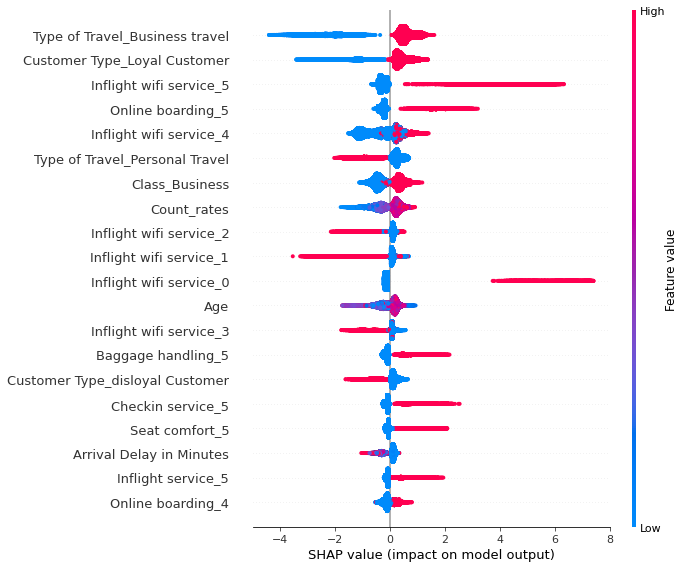

In [100]:
shap.initjs()
shap.summary_plot(shap_values, X_train_)